In [1]:
import os
import cv2
import sklearn
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import layers
from sklearn.metrics import f1_score
import tensorflow as tf   
tf.get_logger().setLevel('ERROR')

mpl.rcParams['figure.figsize'] = (16, 14)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
print(tf.__version__)

2024-12-04 17:12:29.447859: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 17:12:29.455950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733312549.468879   78498 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733312549.471717   78498 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 17:12:29.482047: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

2.18.0


In [3]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 11.6 MB/s eta 0:00:00m eta 0:00:010:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 13.5 MB/s eta 0:00:0031m15.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 11.9 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 10.9 MB/s eta 0:00:00 MB/s eta 0:00:01:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
## Iterate over data folders for classes name and train-test split !!

BASE_DATA_FOLD = 'lalit_data'
TESTING_FOLD = 'lalit_data/test'
TRAINING_FOLD = 'lalit_data/train'

# augmented = False

# if augmented:
#     TRAINING_FOLD = 'augmented_training'
    
# validation_img = 'validation_images.npy'
# validation_labl = 'validation_labels.npy'
# if not augmented:
#     training_img = 'training_images.npy'
#     training_labl = 'training_labels.npy'
# else:
#     training_img = 'aug_training_images.npy'
#     training_labl = 'aug_training_labels.npy'

CWD = os.getcwd()
SRC = os.path.join(CWD, BASE_DATA_FOLD)
print(SRC)
TRAINING_DIR_PATH = os.path.join(CWD, TRAINING_FOLD)
TESTING_DIR_PATH = os.path.join(CWD, TESTING_FOLD)

CLASSES = sorted(os.listdir(SRC))
print(CLASSES)

SRC_DIR_PATHS = [os.path.join(SRC, Class) for Class in CLASSES]
TRAINING_CLASS_DIR_PATHS = [os.path.join(TRAINING_DIR_PATH, Class) for Class in CLASSES]

TESTING_CLASS_DIR_PATHS = [os.path.join(TESTING_DIR_PATH, Class) for Class in CLASSES]

/home/shamsher/aditya/code/lalit_data
['auto-rickshaw', 'bicycle', 'bus', 'car', 'e-rickshaw', 'mini-bus', 'mini-truck', 'motorcycle', 'rickshaw', 'tractor', 'truck', 'van']


In [3]:
print(TRAINING_DIR_PATH)
print(TRAINING_CLASS_DIR_PATHS)
print(TESTING_DIR_PATH)
print(TESTING_CLASS_DIR_PATHS)

/home/shamsher/aditya/code/lalit_data/train
['/home/shamsher/aditya/code/lalit_data/train/auto-rickshaw', '/home/shamsher/aditya/code/lalit_data/train/bicycle', '/home/shamsher/aditya/code/lalit_data/train/bus', '/home/shamsher/aditya/code/lalit_data/train/car', '/home/shamsher/aditya/code/lalit_data/train/e-rickshaw', '/home/shamsher/aditya/code/lalit_data/train/mini-bus', '/home/shamsher/aditya/code/lalit_data/train/mini-truck', '/home/shamsher/aditya/code/lalit_data/train/motorcycle', '/home/shamsher/aditya/code/lalit_data/train/rickshaw', '/home/shamsher/aditya/code/lalit_data/train/tractor', '/home/shamsher/aditya/code/lalit_data/train/truck', '/home/shamsher/aditya/code/lalit_data/train/van']
/home/shamsher/aditya/code/lalit_data/test
['/home/shamsher/aditya/code/lalit_data/test/auto-rickshaw', '/home/shamsher/aditya/code/lalit_data/test/bicycle', '/home/shamsher/aditya/code/lalit_data/test/bus', '/home/shamsher/aditya/code/lalit_data/test/car', '/home/shamsher/aditya/code/lalit_

In [7]:
# CLASSES2=['00-Human Intervention','01-Bike','03-Car Hatchback','04-Car Sedan','05-Car SUV','06-Tractor','07-Jeep Scorpio Bolero','08-PickUp','09-Car Omni','11-Tata Ace','13-LCV 2 Axle Truck','14-LCV 2 Axle Bus','17-Truck 2 Axle  Big','22-Truck 2 Axle loading','23-Bus 2 Axle Big','26-MAV 3 Axle Truck','30-MAV 4 Axle','31-MAV 4 lifted axle','32-MAV 4 Axle trailer','33-MAV 5 Axle','34-MAV 5 lifted axle','35-MAV 5 Axle Trailer','36-MAV 5 AXLE trailer Lifted','37-MAV 6 Axle','38-MAV 6 Axle Lifted']
# CLASSES2.sort()
# print(CLASSES2)
# len(CLASSES2)


In [4]:
# len(CLASSES2)

In [5]:
import random
import shutil
from shutil import copyfile
## Create Training and Testing folders !!
for path in TRAINING_CLASS_DIR_PATHS:
    os.makedirs(path, exist_ok=True)
for path in TESTING_CLASS_DIR_PATHS:
    os.makedirs(path, exist_ok=True)

# Split data in train & test !!
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE=0.8):
    for fname in random.sample(os.listdir(SOURCE), len(os.listdir(SOURCE))):
        if (fname.endswith('jpg') or fname.endswith('bmp') or fname.endswith('png') or fname.endswith('jpeg')):
            source = os.path.join(SOURCE, fname)
            if(os.path.getsize(source) != 0):
                if(len(os.listdir(TRAINING)) < len(os.listdir(SOURCE))*SPLIT_SIZE):
                    destination = os.path.join(TRAINING, fname)
                else:
                    destination = os.path.join(TESTING, fname)
                copyfile(source, destination)


for path in zip(SRC_DIR_PATHS, TRAINING_CLASS_DIR_PATHS, TESTING_CLASS_DIR_PATHS):
    print('Splitting Data from...', path[0])
    split_data(path[0], path[1], path[2])

Splitting Data from... /home/shamsher/aditya/code/lalit_data/auto-rickshaw
Splitting Data from... /home/shamsher/aditya/code/lalit_data/bicycle
Splitting Data from... /home/shamsher/aditya/code/lalit_data/bus
Splitting Data from... /home/shamsher/aditya/code/lalit_data/car
Splitting Data from... /home/shamsher/aditya/code/lalit_data/e-rickshaw
Splitting Data from... /home/shamsher/aditya/code/lalit_data/mini-bus
Splitting Data from... /home/shamsher/aditya/code/lalit_data/mini-truck
Splitting Data from... /home/shamsher/aditya/code/lalit_data/motorcycle
Splitting Data from... /home/shamsher/aditya/code/lalit_data/rickshaw
Splitting Data from... /home/shamsher/aditya/code/lalit_data/tractor
Splitting Data from... /home/shamsher/aditya/code/lalit_data/truck
Splitting Data from... /home/shamsher/aditya/code/lalit_data/van


In [6]:
print('Training Data Img Count per Class:')
img_count = list()
for i, path in enumerate(TRAINING_CLASS_DIR_PATHS):
    count = len(os.listdir(path))
    img_count.append(count)
    print(i,':', path.split('/')[-1], ':', count)
    
print(f'Max:{max(img_count)} , Min:{min(img_count)}')
print('\nTotal Training images:', sum(img_count))
#
img_count.clear()
print('\nTesting Data Img Count per Class:')
for i, path in enumerate(TESTING_CLASS_DIR_PATHS):
    count = len(os.listdir(path))
    img_count.append(count)
    print(i,':', path.split('/')[-1], ':', count)
print('\nTotal Testing images:', sum(img_count))

Training Data Img Count per Class:
0 : auto-rickshaw : 470
1 : bicycle : 123
2 : bus : 160
3 : car : 156
4 : e-rickshaw : 74
5 : mini-bus : 54
6 : mini-truck : 325
7 : motorcycle : 207
8 : rickshaw : 29
9 : tractor : 87
10 : truck : 182
11 : van : 392
Max:470 , Min:29

Total Training images: 2259

Testing Data Img Count per Class:
0 : auto-rickshaw : 117
1 : bicycle : 30
2 : bus : 39
3 : car : 38
4 : e-rickshaw : 18
5 : mini-bus : 13
6 : mini-truck : 81
7 : motorcycle : 51
8 : rickshaw : 7
9 : tractor : 21
10 : truck : 45
11 : van : 97

Total Testing images: 557


In [8]:
validation_img = 'validation_images.npy'
validation_labl = 'validation_labels.npy'
training_img = 'training_images.npy'
training_labl = 'training_labels.npy'

# if not augmented:
#     training_img = 'training_images.npy'
#     training_labl = 'training_labels.npy'
# else:
#     training_img = 'aug_training_images.npy'
#     training_labl = 'aug_training_labels.npy'

if not (os.path.exists(training_img) and os.path.exists(training_labl)
    and os.path.exists(validation_img) and os.path.exists(validation_labl)):
    
    training_images= list()
    training_labels= list()
    validation_images= list()
    validation_labels= list()

    if not(os.path.exists(training_img) and os.path.exists(training_labl)): 
        IMAGES = [os.path.join(fold, image) for fold in TRAINING_CLASS_DIR_PATHS for image in os.listdir(fold)]
        print('Loading Training Data ....')
        print(len(IMAGES))
        for img in IMAGES:
            im = plt.imread(img)
            training_images.append(cv2.resize(im, (224, 224)))
            training_labels.append(CLASSES.index(img.split('/')[-2]))
        print('Training_images_size:', len(training_images))
        print('Training_labels_size:', len(training_labels))
        print('\nSaving Training Data and Labels in np format...')
        training_images = np.array(training_images)
        np.save(training_img, training_images)
        training_labels = np.array(training_labels)
        np.save(training_labl, training_labels)
        IMAGES.clear()
        print('Saving Done !!')
    else:
        print('\nLoading Training data from numpy files...')
        training_images = np.load(training_img)
        training_labels = np.load(training_labl)
        print('Loading Done !!')

    
    if not(os.path.exists(validation_img) and os.path.exists(validation_labl)):
        IMAGES = [os.path.join(fold, image) for fold in TESTING_CLASS_DIR_PATHS for image in os.listdir(fold)]
        print('\nLoading Validation Data ....')
        print(len(IMAGES))
        for img in IMAGES:
            try:
                im = plt.imread(img)
                validation_images.append(cv2.resize(im, (224, 224)))
                validation_labels.append(CLASSES.index(img.split('/')[-2]))
            except OSError as e:
                print(f"Skipping corrupted image: {img}, error: {e}")
                continue

        print('Validation_images_size:', len(validation_images))
        print('Validation_labels_size:', len(validation_labels))

        print('Saving Validation Data and Labels in np format...')
        validation_images = np.array(validation_images)
        np.save(validation_img, validation_images)
        validation_labels = np.array(validation_labels)
        np.save(validation_labl, validation_labels)
        IMAGES.clear()
        print('Saving Done !!')
    else:
        print('\nLoading Validation data from numpy files...')
        validation_images = np.load(validation_img)
        validation_labels = np.load(validation_labl)
        print('Loading Done !!')        

else:
    print('Loading data from numpy files...')
    training_images = np.load(training_img)
    training_labels = np.load(training_labl)
    validation_images = np.load(validation_img)
    validation_labels = np.load(validation_labl)
    print('Loading Done !!')

Loading Training Data ....
2259
Training_images_size: 2259
Training_labels_size: 2259

Saving Training Data and Labels in np format...
Saving Done !!

Loading Validation Data ....
557
Validation_images_size: 557
Validation_labels_size: 557
Saving Validation Data and Labels in np format...
Saving Done !!


In [9]:
CLASSES2=[item.split('/')[-1] for item in TESTING_CLASS_DIR_PATHS if len(os.listdir(item)) > 0]
CLASSES2.sort()
print(CLASSES2)
len(CLASSES2)

['auto-rickshaw', 'bicycle', 'bus', 'car', 'e-rickshaw', 'mini-bus', 'mini-truck', 'motorcycle', 'rickshaw', 'tractor', 'truck', 'van']


12

In [10]:
training_images = np.load(training_img)
training_labels = np.load(training_labl)
validation_images = np.load(validation_img)
validation_labels = np.load(validation_labl)

In [11]:
METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'), 
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Define a Callback class that stops training once accuracy reaches 99.9%
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=7,
    mode='max',
    restore_best_weights=True)

def preprocess(inputs):
    imgs = inputs.astype('float32')
    processed_input = tf.keras.applications.resnet_v2.preprocess_input(imgs)
    return processed_input

2024-12-04 17:14:48.343416: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-04 17:14:48.343465: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: vishal-hp-zbook-power-15-6-inch-g9-mobile-workstation-pc
2024-12-04 17:14:48.343477: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: vishal-hp-zbook-power-15-6-inch-g9-mobile-workstation-pc
2024-12-04 17:14:48.343610: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 545.23.6
2024-12-04 17:14:48.343641: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 545.23.6
2024-12-04 17:14:48.343651: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 545

In [12]:
def plot_metrics(history):
    metrics = ['accuracy', 'loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,3,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend();

In [13]:
print(len(set(validation_labels)))

12


In [14]:
print('\nProcessing Images ...')
train_X = training_images
valid_X = validation_images

training_labels = tf.keras.utils.to_categorical(training_labels,12)
print(training_labels)
validation_labels = tf.keras.utils.to_categorical(validation_labels,12)
print('Processing Done !')


Processing Images ...
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Processing Done !


In [15]:
pre_trained_model = tf.keras.applications.resnet_v2.ResNet50V2(include_top = False, weights = 'imagenet')
processed_input = tf.keras.applications.resnet_v2.preprocess_input
for layer in pre_trained_model.layers[:29]:    #Freeze weights of eight five layers 29
    layer.trainable = False

pre_trained_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, None,      │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, None,      │          0 │ conv2_block1_pre… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, None,      │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, None,      │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,364,096 (89.13 MB)

 Non-trainable params: 200,704 (784.00 KB)

In [16]:
#pip install h5py==2.10 -i https://pypi.tuna.tsinghua.edu.cn/simple/

In [17]:
inputs = tf.keras.Input(shape=(224,224,3))
x = processed_input(inputs)
x = pre_trained_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(12, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_model")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=METRICS)

# Print the model summary
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │        12,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,675,276 (97.94 MB)

 Trainable params: 25,474,572 (97.18 MB)

 Non-trainable params: 200,704 (784.00 KB)

In [18]:
# # Create ImageDataGenerator objects
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range = 0.2, brightness_range=[0.2,0.8], preprocessing_function=preprocess)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

In [21]:
train_data_generator = train_datagen.flow_from_directory(
    TRAINING_DIR_PATH,
    target_size=(224,224),
    class_mode='categorical'
)

test_data_generator = train_datagen.flow_from_directory(
    TESTING_DIR_PATH,
    target_size=(224,224),
    class_mode='categorical',
    shuffle=False
)

BATCH_SIZE = 16
#tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):
    history = model.fit(train_X, training_labels, epochs=30, validation_data = (valid_X, validation_labels), batch_size=BATCH_SIZE, callbacks=[early_stopping])
    #history = model.fit(train_data_generator, validation_data=test_data_generator, batch_size=BATCH_SIZE, epochs=25, callbacks=[early_stopping],workers=32)

Found 2259 images belonging to 12 classes.
Found 557 images belonging to 12 classes.
Epoch 1/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.3344 - auc: 0.8343 - fn: 978.4685 - fp: 80.7902 - loss: 1.8271 - prc: 0.3530 - precision: 0.6419 - recall: 0.1302 - tn: 12587.9795 - tp: 173.2378 - val_accuracy: 0.3537 - val_auc: 0.8376 - val_fn: 426.0000 - val_fp: 88.0000 - val_loss: 1.8953 - val_prc: 0.4063 - val_precision: 0.5982 - val_recall: 0.2352 - val_tn: 6039.0000 - val_tp: 131.0000
Epoch 2/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 130s 913ms/step - accuracy: 0.4031 - auc: 0.8610 - fn: 888.3986 - fp: 78.9930 - loss: 1.6581 - prc: 0.4575 - precision: 0.7711 - recall: 0.2293 - tn: 12589.7764 - tp: 263.3077 - val_accuracy: 0.4345 - val_auc: 0.8765 - val_fn: 383.0000 - val_fp: 72.0000 - val_loss: 1.5902 - val_prc: 0.5143 - val_precision: 0.7073 - val_recall: 0.3124 - val_tn: 6055.0000 - val_tp: 174.0000
Epoch 3/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 131s 922ms/step - accuracy: 0.4147 - auc: 0.8719

In [41]:
# # Save the entire modelmodel.save("resnet_50lat.h5")
#model.save('data_save1.h5')
model.save('resner_r.keras')

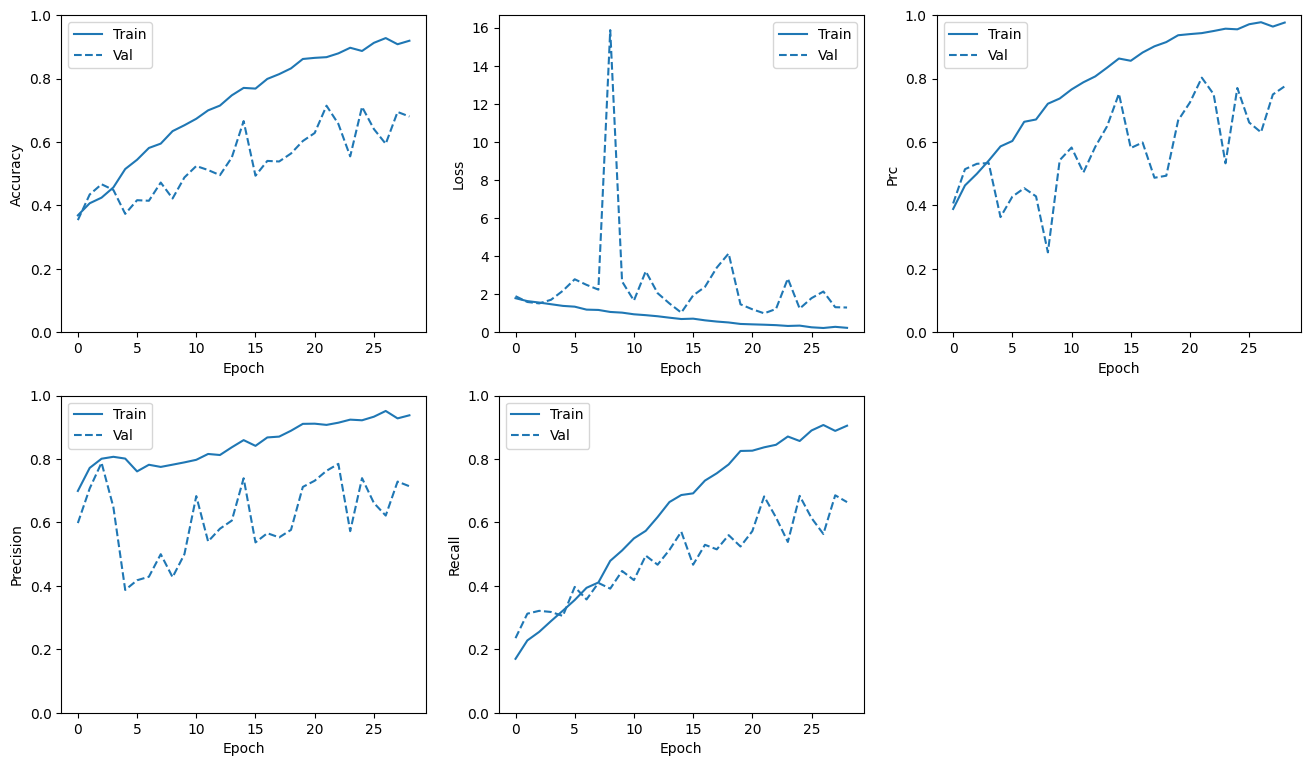

In [42]:
plot_metrics(history)

In [43]:
# Load the model
model = tf.keras.models.load_model('resner_r.keras')

/home/shamsher/miniconda3/envs/ocr_test/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 152 variables whereas the saved optimizer has 302 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [46]:
# Load and preprocess the image
image = cv2.imread('/home/shamsher/piyush/resnet_cat_dog/lalit_data/test/auto-rickshaw/0_2out13-00-09353.png')
image_resized = cv2.resize(image, (224, 224))  # Resize to expected input size
image_normalized = image_resized.astype('float32') / 255.0  # Normalize if needed
image_input = np.expand_dims(image_normalized, axis=0)  # Add batch dimension
# Run inference
predictions = model.predict(image_input)

# Get the predicted class index
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Get the confidence score for the predicted class
confidence_score = np.max(predictions)


# Print the predicted class name and the confidence score
print(f"Predicted Class:", {predicted_class_index})
print(f"Confidence Score: {confidence_score:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted Class: {0}
Confidence Score: 0.9868


In [22]:
# validation_images = np.load(validation_img)
# validation_labels = np.load(validation_labl)

# # valid_X = preprocess(validation_images)
# valid_X = validation_images/255.
# validation_labels = tf.keras.utils.to_categorical(validation_labels,50)

In [23]:


# validation_index = validation_labels
# predictions_index = tf.argmax(test_predictions, axis=1)

In [24]:
# test_data_generator.reset()
# results = model.evaluate_generator(generator=test_data_generator, workers = 1)
# predictions = model.predict_generator(generator=test_data_generator, workers = 1)
# predictions_index = np.argmax(predictions, axis=1)
# # test_data_generator.reset()
# validation_index = test_data_generator.classes#[test_data_generator.index_array]

In [47]:
results = model.evaluate(valid_X, validation_labels)
for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
print()
test_predictions = model.predict(x=valid_X)
validation_index = tf.argmax(validation_labels, axis=1)
predictions_index = tf.argmax(test_predictions, axis=1)

# print('f1_score:',f1_score(validation_labels, test_predictions))

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 444ms/step - accuracy: 0.7263 - auc: 0.9513 - fn: 101.8421 - fp: 66.5789 - loss: 0.9787 - prc: 0.8084 - precision: 0.7836 - recall: 0.6944 - tn: 3412.8948 - tp: 214.4737
loss :  0.9944142699241638
compile_metrics :  380.0

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 448ms/step


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 478ms/step - accuracy: 0.7263 - auc: 0.9513 - fn: 101.8421 - fp: 66.5789 - loss: 0.9787 - prc: 0.8084 - precision: 0.7836 - recall: 0.6944 - tn: 3412.8948 - tp: 214.4737
loss :  0.9944142699241638
compile_metrics :  380.0

18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 858ms/step


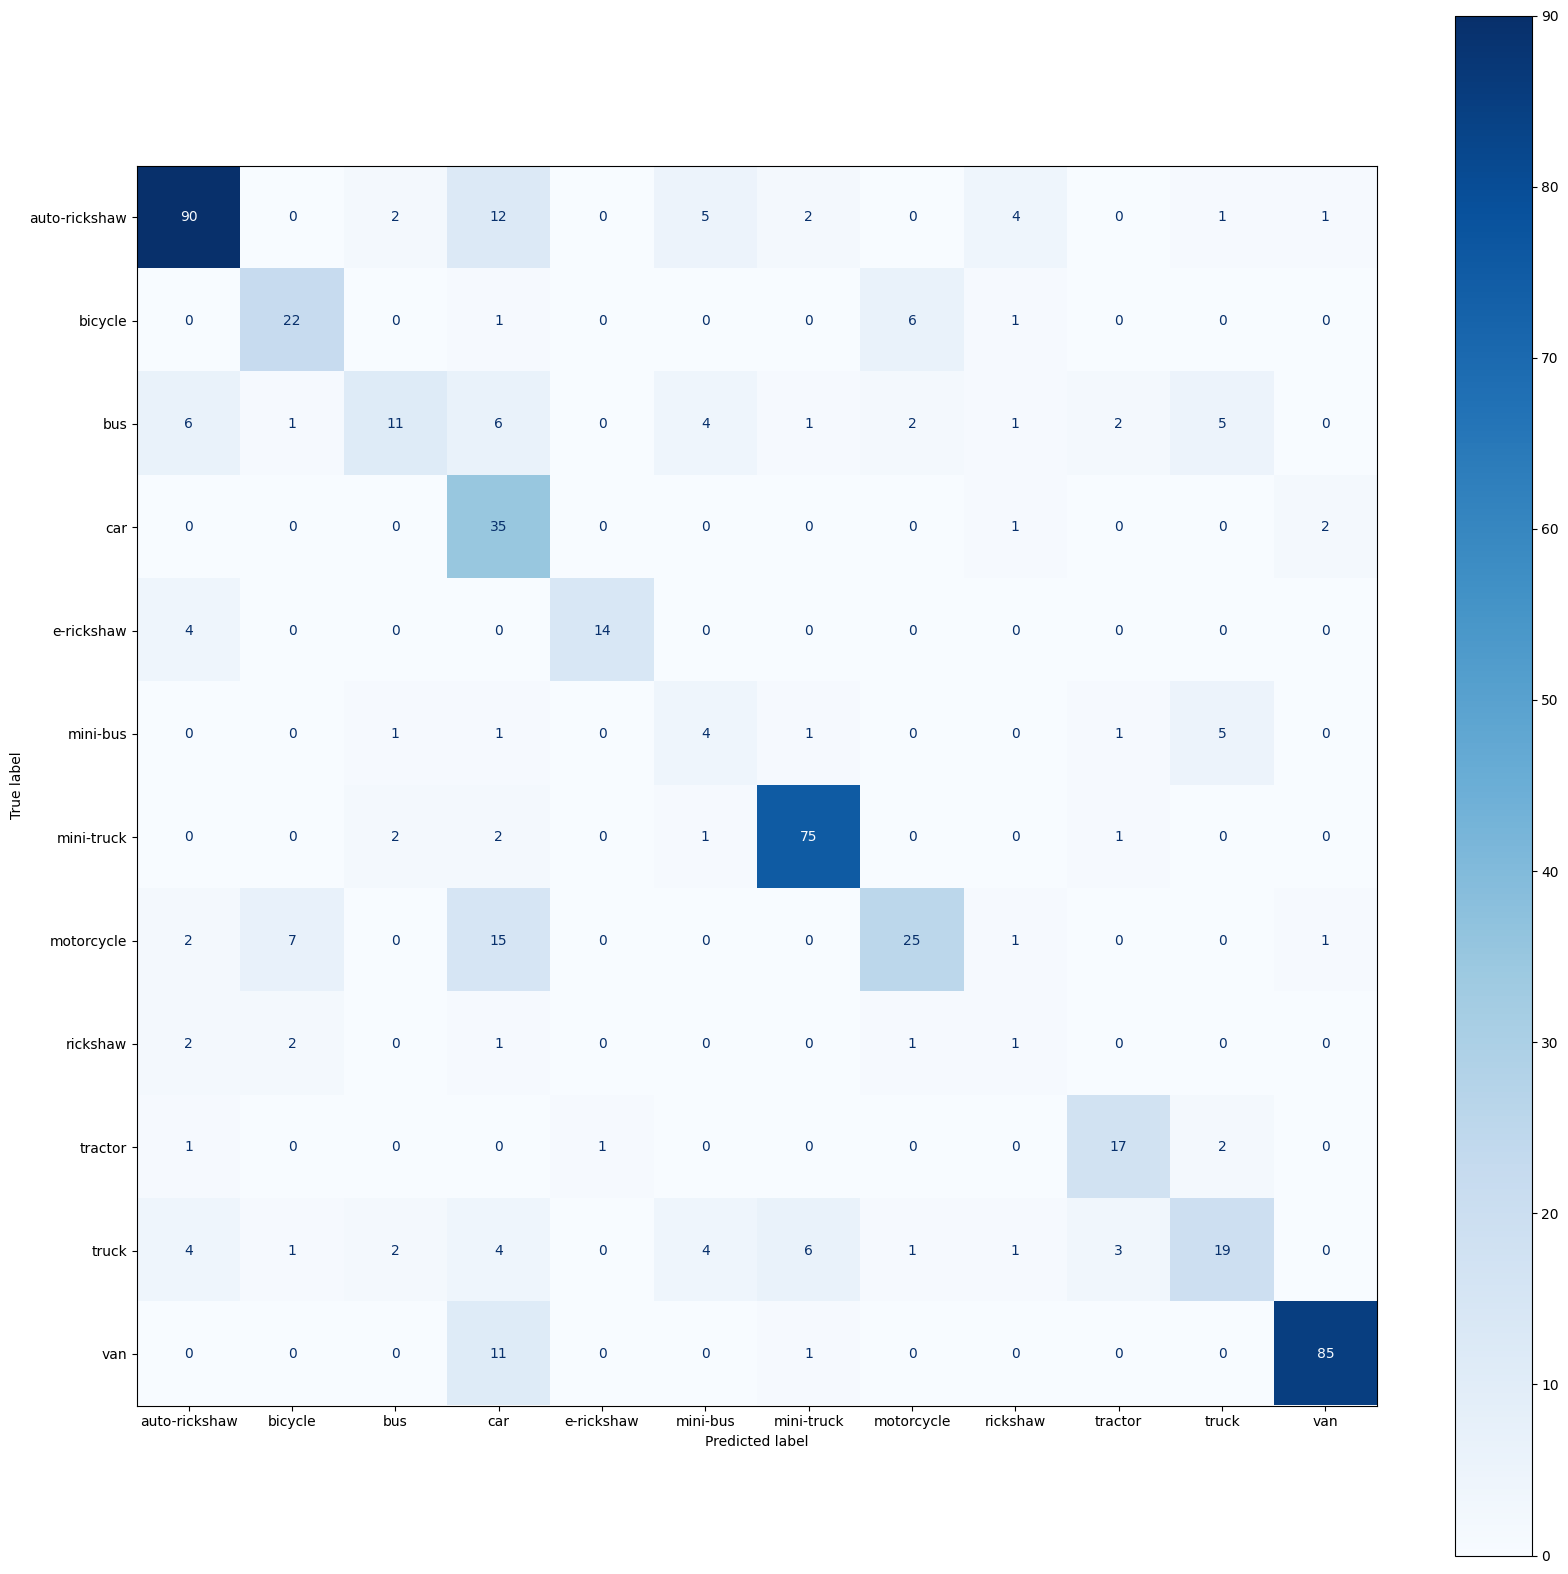

In [48]:
results = model.evaluate(valid_X, validation_labels)
for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
print()
test_predictions = model.predict(x=valid_X)
validation_index = tf.argmax(validation_labels, axis=1)
predictions_index = tf.argmax(test_predictions, axis=1)

# print('f1_score:',f1_score(validation_labels, test_predictions))

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
## Plot Confusion matrix !! 
plt.rcParams['figure.figsize'] = [20, 20]
cm = confusion_matrix(validation_index, predictions_index)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES2)

disp.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:
## Model fine tuning !!
pre_trained_model.trainable = True
for layer in pre_trained_model.layers[:18]:    #Freeze weights of eight five layers
    layer.trainable = False

#pre_trained_model.summary()
# model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=METRICS,
)
with tf.device('/GPU:0'):
    history = model.fit(train_X, training_labels, epochs=15, validation_data = (valid_X, validation_labels), batch_size=BATCH_SIZE, callbacks=[early_stopping])
    #history = model.fit(train_data_generator, validation_data=test_data_generator, batch_size=32, epochs=15, callbacks=[early_stopping], workers=32)

Epoch 1/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.8242 - auc: 0.9788 - fn: 334.8881 - fp: 193.9301 - loss: 0.3327 - prc: 0.8998 - precision: 0.8641 - recall: 0.7902 - tn: 18601.8398 - tp: 1373.8182 - val_accuracy: 0.7630 - val_auc: 0.9632 - val_fn: 155.0000 - val_fp: 92.0000 - val_loss: 0.8247 - val_prc: 0.8429 - val_precision: 0.8138 - val_recall: 0.7217 - val_tn: 6035.0000 - val_tp: 402.0000
Epoch 2/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.9181 - auc: 0.9971 - fn: 133.6783 - fp: 54.8531 - loss: 0.2555 - prc: 0.9761 - precision: 0.9500 - recall: 0.8868 - tn: 12613.9160 - tp: 1018.0280 - val_accuracy: 0.7756 - val_auc: 0.9652 - val_fn: 145.0000 - val_fp: 85.0000 - val_loss: 0.7912 - val_prc: 0.8505 - val_precision: 0.8290 - val_recall: 0.7397 - val_tn: 6042.0000 - val_tp: 412.0000
Epoch 3/15
142/142 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.9351 - auc: 0.9968 - fn: 117.2168 - fp: 45.2168 - loss: 0.2387 - prc: 0.9793 - precision: 0.9564 - recall:

In [ ]:
plot_metrics(history)

In [ ]:
# test_data_generator.reset()
# predictions = model.predict_generator(generator=test_data_generator,
#                                     steps=test_data_generator.samples//32,
#                                     max_queue_size=10,
#                                     workers=0,
#                                     use_multiprocessing=False,
#                                     verbose=0)
# predictions_index = np.argmax(predictions, axis=1)
# validation_index = test_data_generator.classes[test_data_generator.index_array]

In [ ]:
results = model.evaluate(valid_X, validation_labels, verbose=0,workers=0)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)
print()

test_predictions = model.predict(x=valid_X)

validation_index = tf.argmax(validation_labels, axis=1)
predictions_index = tf.argmax(test_predictions, axis=1)

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
## Plot Confusion matrix !! 
plt.rcParams['figure.figsize'] = [20, 20]
cm = confusion_matrix(validation_index, predictions_index)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES2)

disp.plot(cmap=plt.cm.Greens)
plt.show()

In [ ]:
tf.keras.models.save_model(model, './savedModel/resnet50V2_fineTuned_C-AVC_301122.h5', save_format='h5')
model.save('./C-AVC_model_301122/')
print("Model Saved !!")

### Training Done !!!